# Probability Distributions and Random Variables

Throughout the course we will work with probability distributions. Hence, it is important to master the basic principles of probability distributions, and learn to manipulate probabilities in code.

Probability distributions and random variables serve as tools for describing and performing calculations related to random events, specifically those whose outcomes are uncertain. An illustrative instance of such an uncertain event would be the act of flipping a coin or rolling a dice. In the former case, the potential outcomes are heads or tails. An example from epidemiology, is the number of disease cases on a given day.

In the context of epidemiological modelling, we will encounter data of different type and origin. It is crucial to grasp the suitability of different probability distributions for modeling specific types of data.

Since the probabilistic programming language that we will be using for this course is **Numpyro**, also in this section we will use the implementations of distributions from this library avalable via `import numpyro.distributions as dist`

In [1]:
# uncomment this line on Colab
# !pip install numpyro

```{margin}
In all notebooks od this course, we will always import all necessary libraries in the first code cell.
```

In [2]:
import jax
import jax.numpy as jnp

# dsitributions
import numpyro.distributions as dist

import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Since we are using jax, we will need a random key:
rng = jax.random.PRNGKey(42)

/opt/anaconda3/envs/aims/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Discrete Distributions

Discrete probability distributions represent the probabilities of distinct outcomes in a <span style="color:orange">finite</span> or <span style="color:orange">countably infinite</span> sample space.

### The Bernoulli distribution

A Bernoulli distribution is used to describe random events with <span style="color:orange">two possible outcomes</span> e.g. when we have a random variable $X$ that takes on one of the two values $x \in \{0, 1\}$ with probabilities $1-p$ and $p, 0 \le p \le 1$ respectively:

\begin{align*}
p(X = 1) &= p, \\
p(X = 0) &= 1 - p.
\end{align*}

Here $p$ is the probability of the 'positive' outcome. For example, in the case of a *fair* coin toss, $p = 0.5$ so that both outcomes have a 50\% chance of occurring. As we will see shortly, most distributions have multiple parameters.

We will be denoting this distribution as 

$$
\mathcal{Bern}(p).
$$

#### Probability mass function
A *discrete* probability distribution can be uniquely defined by its <span style="color:orange">probability mass function (PMF)</span>.

```{margin}
The term 'mass' is used to underline that the support of the distribution is discrete, and each possible value carries a certain `mass` (probability).
For continuous distributions, the analogous is *probability density function (PDF)*, we will see those later.
```
For the Bernoulli distribution, we write the PMF as

\begin{align*}
p(X = x) = \mathcal{Bern}(X\mid p) &= \begin{cases}
p\, & \text{if } x = 1 \\
1 - p\, & \text{if } x = 0
\end{cases} \\
&= p^x(1-p)^{1-x}.
\end{align*}

**Exercise:** convince yourself that the two definitions of the Bernoulli distribution shown above are equivalent.

Now let's construct a Bernoulli distribution in code.

#### Drawing a sample

We construct the distribution with a certain value of the parameter `p`:

In [3]:
p = jnp.array(0.5)
bernoulli = dist.Bernoulli(probs=p)

Now that we have constructed the distribution we can get a *sample* from it:

```{margin}
We can think of a sample as a <span style="color:orange">realisation</span> of a random variable. 
```

In [4]:
sample = bernoulli.sample(key=rng)
print(sample)

1


And we can evaluate the probability of observing a sample.

**Note:** the distribution objects in `numpyro` (and most other libraries for probability distributions) return <span style="color:orange">*log*-probabilities</span> rather than raw probabilities. This means that we need to take the exponent if we want to know the probability.

In [5]:
log_prob = bernoulli.log_prob(sample)
print(f"log p(X = {sample}) = {log_prob}")
print(f"p(X = {sample}) = {jnp.exp(log_prob)}")

log p(X = 1) = -0.6931471824645996
p(X = 1) = 0.5


As expected, we get a probability of 0.5.

#### Multiple samples

We can also easily get multiple samples in one command:

```{margin}
Multiple samples are different realisations of the <span style="color:orange">same</span> random variable.
```

In [6]:
n_samps = 7
samples = bernoulli.sample(key=rng, sample_shape=(n_samps,))
print(samples)

[0 0 1 1 0 1 1]


What if we wanted to evaluate the probability of observing all of our samples?

The `bernoulli` object we created earlier treats each sample individually and returns the probabilities of observing each sample on its own:

In [7]:
individual_sample_probs = jnp.exp(bernoulli.log_prob(samples))
print(individual_sample_probs)

[0.5 0.5 0.5 0.5 0.5 0.5 0.5]


But, we can use one of the laws of probability to compute the probability of observing all of the samples together:

\begin{align*}
p(X_1=x_1, X_2=x_2, \dots, X_N=x_n) = \prod_{n=1}^N p(X_n=x_n).
\end{align*}

This is called the <span style="color:orange">product rule of probability</span>, and it says that for *independent* random variables, the joint probability (i.e., the probability of observing them all together) is equal to the product of the individual probabilities.

Now, let's calculate the joint probability of our samples.

```{margin}
Working with log-probabilities is preferable due to numerical stability, computational efficiency, and ease of handling multiplicative operations.
```

In [8]:
joint_prob = jnp.prod(individual_sample_probs)
print(joint_prob)

0.0078125


#### Visualise PMF

Now let's visualise the PMF:

In [9]:
def Bernouilli_vis(rng, p, n_samps):

    # define distribution
    bernoulli_ = dist.Bernoulli(probs=p)

    # collect samples
    samples = bernoulli_.sample(key=rng, sample_shape=(n_samps,))

    # how many ones
    num_ones = (samples == 1.).sum()

    # how many zeros
    num_zeros = (samples == 0.).sum()

    # plot
    fig = plt.figure(dpi=100, figsize=(5, 3))
    ax = fig.add_subplot(1, 1, 1)
    ax.bar([0, 1], [num_zeros/n_samps, num_ones/n_samps], alpha=0.7, color='teal')
 
    ax.set_xticks([0, 1])
    ax.set_xlabel('Outcome (x)')
    ax.set_ylabel('Probability Mass p(X=x)')
    ax.set_title(f'Bernoulli Distribution (p={p})')
    ax.grid(True)
    
    plt.show()



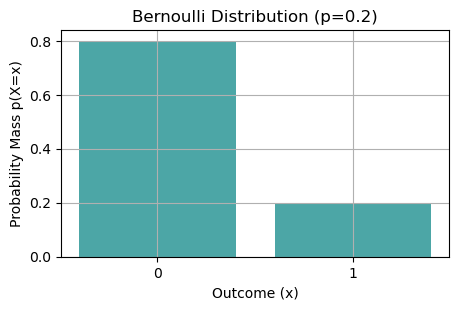

In [10]:
Bernouilli_vis(rng, p=0.2, n_samps=10)

`````{admonition} Task
:class: tip
Recreate this plot using `bernoulli.log_prob(sample)` functionality (see examples below).
`````

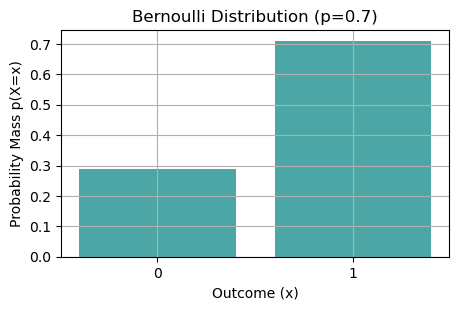

In [11]:
Bernouilli_vis(rng, p=0.7, n_samps=100)

`````{admonition} Task
:class: tip
Plot a panel of histograms where you vary probability $p$ horizontally and number of samples $n$ vertically. What do you observe?
`````

#### Common usage

Bernoulli dsitribution is commonly used as a likelihood in models with binary outcomes, such as presence or absence of a disease.

### The Binomial distribution

A binomial distribution is a discrete probability distribution that models the <font color='orange'>number of successes</font> "x" in a fixed number of independent and identical Bernoulli trials, where each trial has only two possible outcomes: success or failure. 

Key characteristics of a binomial distribution:

- Two Outcomes: each trial results in one of two possible outcomes, typically denoted as "success" (represented as "1") or "failure" (represented as "0" or "not a success").

- Fixed Number of Trials ($n$): the distribution considers a fixed number of trials, denoted as $n$, which is the total number of times the event is repeated.

- Probability of Success ($p$): the probability of success on each individual trial is constant and denoted as $p$. 

- Independence: each trial is assumed to be independent, meaning the outcome of one trial does not affect the outcome of another.

We will use the notation 

$$
\mathcal{Binom}(n,p)
$$

#### Probability mass function

The PMF of the Bernoulli distribution is

$$P(X = x) = \binom{n}{x} p^x (1 - p)^{n - x},$$

where

- $P(X = x)$ is the probability of getting exactly $x$ successes,

- $\binom{n}{x}$ is the binomial coefficient, representing the number of ways to choose $x$ successes out of $n$ trials,

- $p$ is the probability of success on a single trial,

- $1-p$ is the probability of failure on a single trial,

- the bnumber of successes $x$ ranges from $0$ to $n$ inclusive.

`````{admonition} Task
:class: tip
Compute $\sum_{x=0}^n P(X=x)$.
`````

#### Drawing a sample

As before, we begin by constructing the distribution:

In [12]:
p = 0.3
n = 10
binomial = dist.Binomial(total_count=n, probs=p)

Now we can draw a sample from this distribution:

In [13]:
sample = binomial.sample(key=rng)
print(sample)

4


What is the probability to observe this sample?

In [14]:
log_prob = binomial.log_prob(sample)
print(f"log p(X = {sample}) = {log_prob}")
print(f"p(X = {sample}) = {jnp.exp(log_prob)}")

log p(X = 4) = -1.608832836151123
p(X = 4) = 0.20012104511260986


#### Multiple samples

Let us generate samples repeatedly: 

In [15]:
n_samps = 7
samples = binomial.sample(key=rng, sample_shape=(n_samps,))
print(samples)

[3 6 1 3 2 4 5]


Individual probabilities to observe the samples:

In [16]:
individual_sample_probs = jnp.exp(binomial.log_prob(samples))
print(individual_sample_probs)

[0.26682812 0.03675695 0.12106086 0.26682812 0.23347507 0.20012105
 0.10291947]


Assuming that the samples are independent, what is the joint probability ob observeing them?

In [17]:
joint_prob = jnp.prod(individual_sample_probs)
print(joint_prob)

1.5234818e-06


#### Visualise PMF

In [18]:
def binomial_vis(rng, p, n, x_ticks=True):
    
    # Binomial distribution with n trials and probability of success p
    binomial = dist.Binomial(total_count=n, probs=p)
    
    # Generate the possible outcomes (x values)
    x_values = jnp.arange(0, n + 1)

    pmf_values = jnp.exp(binomial.log_prob(x_values))

    # Create a bar plot (PMF plot)
    fig = plt.figure(dpi=100, figsize=(5, 3))
    plt.bar(x_values, pmf_values, align='center', alpha=0.7, color='teal')
    plt.xlabel('Number of Successes (x)')
    plt.ylabel('Probability Mass p(X=x)')
    plt.title(f'Binomial Distribution (n={n}, p={p})')
    if x_ticks:
        plt.xticks(x_values)
    plt.grid( linestyle='--', alpha=0.7)

    plt.show()


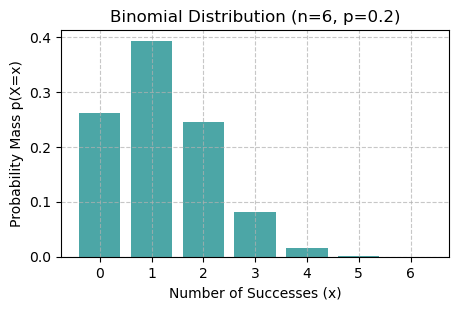

In [19]:
binomial_vis(rng, p=0.2, n=6)

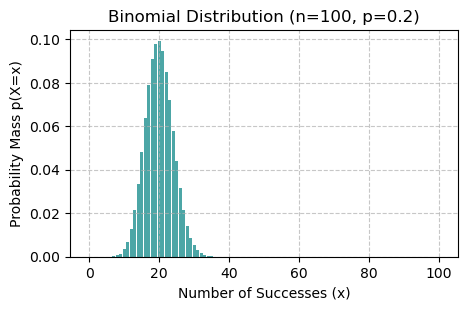

In [20]:
binomial_vis(rng, p=0.2, n=100, x_ticks=False)

`````{admonition} Task
:class: tip
What is qualitatively different between the distributions `Bernoulli(p=0.2, n=6)` and `Bernoulli(p=0.2, n=100)`?
`````

#### Common usage

Binomial dsitribution is commonly used as a likelihood in models with binary outcomes with multiple experiments. For example, to model disease prevalence.

### The Categorical distribution

A categorical distribution is used to model random events with multiple *discrete* outcomes, such as the die-rolling event from above. 

We can characterise the categorical distribution with its PMF:

$$
\begin{align*}
p(X = x) = \mathcal{Categorical}(X \mid p) = \prod_{k=1}^K p_k^{I_{x=k}},
\end{align*}
$$

where $K$ is the number of possible outcomes, $p_k$ is the probability of the $k$th outcome, and $I_{x=k}$ is the indicator function which evaluates to 1 if $x = k$ and 0 otherwise. All porbabilties $p_k$ form a vector

$$
p = 
\begin{pmatrix}
p_1\\ 
p_2\\
\dots \\ 
p_K
\end{pmatrix},
$$



such that 

$$
\sum_k p_k = 1.
$$

`````{admonition} Task
:class: tip
Explain why a categorical distribution with $K = 2$ is equivalent to a Bernoulli distribution.
`````

In [21]:
ps = jnp.array([0.1, 0.2, 0.3, 0.4])
categorical = dist.Categorical(probs=ps)

As before we can take some samples:

In [22]:
samples = categorical.sample(key=rng, sample_shape=(10,))
print(samples)

[3 2 1 3 3 1 2 1 3 3]


In [23]:
print(f"p(X=0) = {jnp.exp(categorical.log_prob(0)):.1f}")
print(f"p(X=1) = {jnp.exp(categorical.log_prob(1)):.1f}")
print(f"p(X=2) = {jnp.exp(categorical.log_prob(2)):.1f}")
print(f"p(X=3) = {jnp.exp(categorical.log_prob(3)):.1f}")

p(X=0) = 0.1
p(X=1) = 0.2
p(X=2) = 0.3
p(X=3) = 0.4


We can use an alternative way to represent the categorical distribution. Instead of specifying the probabilities $p_k$, we specify logits $l_k$. Each $p_k$ is then computed as

$$
p_k = \frac{\exp(l_k)}{\sum_{k'}\exp(l_{k'})},
$$

i.e., using the softmax function.

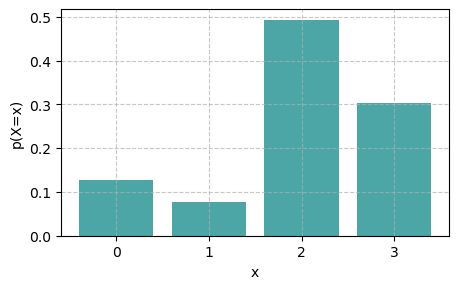

In [24]:
l_0 = 0.7 
l_1 = 0.3 
l_2 = 2 
l_3 = 1.6

logits = jnp.array([l_0, l_1, l_2, l_3], dtype=jnp.float32)
categorical = dist.Categorical(logits=logits)
samples = categorical.sample(key=rng, sample_shape=(1000,))

values =[0, 1, 2, 3]
hist, _ = jnp.histogram(samples, bins=jnp.array(values + [4]), density=True)

fig = plt.figure(dpi=100, figsize=(5, 3))
#ax = fig.add_subplot(1, 1, 1)
plt.bar(values, hist, color='teal', alpha=0.7)
plt.xticks(values)
plt.xlabel('x')
plt.ylabel('p(X=x)')
plt.grid(linestyle='--', alpha=0.7)
plt.show()

## Continuous Distributions

Continuous probability distributions describe the probabilities of outcomes within a continuous range of values.

### The Beta distribution

The Beta distribution is a continuous distribution with support in $[0,1] \subset \mathbb{R}$.
The Beta distribution can be used to describe a continuous random variable between 0 and 1, for example, percentages and ratios. It has the following form

$$
p(X = x) = \mathcal{Beta}(x|\alpha,\beta) = \frac{1}{\mathrm{B}(\alpha,\beta)}x^{\alpha-1}(1 - x)^{\beta - 1},
$$

where $\alpha > 0$ and $\beta > 0$ are the two *shape* parameters of the distribution, and $\mathrm{B}$ is called the beta function. 

Let's visualise the distribution.

`````{admonition} Task
:class: tip
* Try making each parameter big or small while leaving the other at the same value.
* Then try make them both big or small.
`````

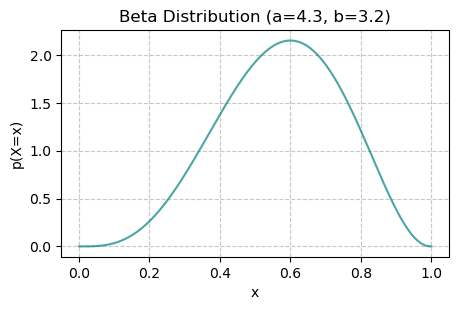

In [25]:
def beta_vis(a, b, x_ticks=True):
    
    beta = dist.Beta(a, b)
    
    x_values = jnp.linspace(0, 1, 1000)

    pmf_values = jnp.exp(beta.log_prob(x_values))

    # Create a bar plot (PMF plot)
    fig = plt.figure(dpi=100, figsize=(5, 3))
    plt.plot(x_values, pmf_values, alpha=0.7, color='teal')
    plt.xlabel('x')
    plt.ylabel('p(X=x)')
    plt.title(f'Beta Distribution (a={a}, b={b})')
    if x_ticks:
        plt.xticks(x_values)
    plt.grid( linestyle='--', alpha=0.7)

    plt.show()

beta_vis(a=4.3, b=3.2, x_ticks=False)

### The Gamma distribution

The Gamma distribution is a continuous distribution with support in $\mathbb{R}^+$.
Its PDF has the form 

$$p(X=x) = \mathcal{Gamma}(x; \alpha, \beta) = \frac{ \beta^{\alpha}}{\Gamma(\alpha)} x^{\alpha - 1} e^{-\beta x},$$

where $\alpha>0$ is the shape parameter, which determines the shape of the distribution, and $\beta>0$ is the scale parameter. 


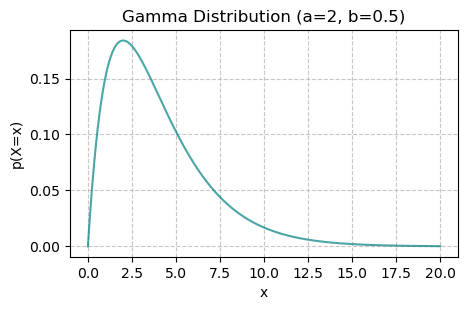

In [26]:
def gamma_vis(a, b, x_ticks=True):
    
    gamma = dist.Gamma(a, b)
    
    x_values = jnp.linspace(0, 20, 1000)

    pmf_values = jnp.exp(gamma.log_prob(x_values))

    # Create a bar plot (PMF plot)
    fig = plt.figure(dpi=100, figsize=(5, 3))
    plt.plot(x_values, pmf_values, alpha=0.7, color='teal')
    plt.xlabel('x')
    plt.ylabel('p(X=x)')
    plt.title(f'Gamma Distribution (a={a}, b={b})')
    if x_ticks:
        plt.xticks(x_values)
    plt.grid( linestyle='--', alpha=0.7)

    plt.show()

gamma_vis(a=2, b=0.5, x_ticks=False)

### The Uniform distribution

Perhaps, the simplest, but still a very important distribution among continuous distributions is the uniform distribution. Under this distribution, all possible values are equally likely. The uniform distribution has the following form

$$
p(X = x) = \mathrm{Uniform}(x\mid a, b) = \begin{cases}
\frac{1}{b - a}\, & \text{if } a \le x \le b \\
0\, & \text{otherwise},
\end{cases}
$$

where $a$ and $b$ are the upper and lower bound parameters, respectively.

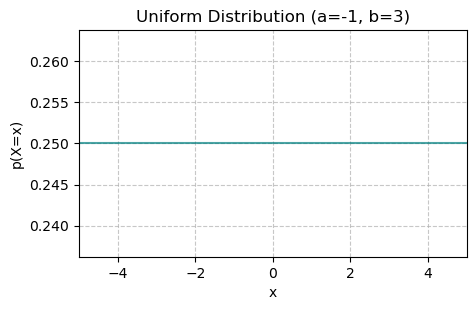

In [27]:
a = -1
b = 3 
x_ticks= False

uniform = dist.Uniform(low=a, high=b)
x_values = jnp.linspace(-5, 5, 1000)

pmf_values = jnp.exp(uniform.log_prob(x_values))

fig = plt.figure(dpi=100, figsize=(5, 3))
plt.plot(x_values, pmf_values, alpha=0.7, color='teal')
plt.xlabel('x')
plt.ylabel('p(X=x)')
plt.title(f'Uniform Distribution (a={a}, b={b})')
if x_ticks:
    plt.xticks(x_values)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xlim(-5, 5)

plt.show()


### The Normal distribution

The normal – also known as *Gaussian* – distribution is one of the most common distributions for modeling *continuous* random variables, i.e., corresponding to events with an uncountable number of outcomes. Its probability density function is

$$
p(X = x) = \mathcal{N}(x\mid \mu, \sigma) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(-\frac{(\mu - x)^2}{2\sigma^2}\right),
$$

where $\mu$ and $\sigma$ are the *mean* and *standard deviation* (also called the location, and scale or square-root of the *variance* $\sigma^2$, respectively).

`````{admonition} Task
:class: tip
How do the mean and standard deviation affect the samples?
`````

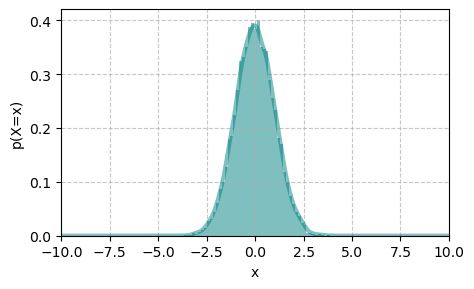

In [28]:
mu = 0 
sigma = 1 

normal = dist.Normal(loc=mu, scale=sigma)
samples = normal.sample(key=rng, sample_shape=(10000,))

fig = plt.figure(dpi=100, figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.hist(samples, bins=50, density=True, alpha=0.5, color='teal')
x = jnp.linspace(-10, 10, 3000)
kde = gaussian_kde(samples)
ax.plot(x, kde(x), lw=3, alpha=0.5, color= 'teal')
ax.set_xlabel('x')
ax.set_ylabel('p(X=x)')
ax.set_xlim(-10, 10)
ax.grid(0.3, linestyle='--', alpha=0.7)
plt.show()

Let us implement and test the normal PDF from scratch:

In [29]:
def test_normal_pdf(pdf_fn):
  assert pdf_fn(0, 1, 0) == jnp.exp(dist.Normal(loc=0, scale=1).log_prob(0)), "Normal(X=0|0, 1) is incorrect."
  assert pdf_fn(0, 2, 0) == jnp.exp(dist.Normal(loc=0, scale=2).log_prob(0)), "Normal(X=0|0, 2) is incorrect."
  assert pdf_fn(0, 1, 1) == jnp.exp(dist.Normal(loc=0, scale=1).log_prob(1)), "Normal(X=0|1, 1) is incorrect."
  assert pdf_fn(2, 3, 1) == jnp.exp(dist.Normal(loc=2, scale=3).log_prob(1)), "Normal(X=1|2, 3) is incorrect."
  print("Nice! Your answer looks correct.")

In [30]:
def normal_pdf(loc, scale, x):
    p_x = 1 / jnp.sqrt(2 * jnp.pi * scale**2)
    p_x *= jnp.exp(-((loc - x)**2) / (2 * scale**2))

    return p_x

test_normal_pdf(normal_pdf)

Nice! Your answer looks correct.


### The Multivariate Normal distribution

```{margin}
This distribution will be very useful in chapters where we will talk about Gaussian Processes and spatial modelling.
```

The *multivariate normal distribution* is a generalization of the *univariate normal distribution* to consider multiple random variables that have a <font color='orange'>jointly normal distribution</font>. In other words, it lets us model variables that are not independent – if we know the value of one variable, that tells us something about the other variables!
More concretely, the multivariate normal distribution lets us consider multiple random variables such that when we condition on some of these variables the remaining variables have a normal distribution. These variables are distributed in a kind of stretched fuzzy ball in higher dimensional space.

As a rule of thumb, the more one variable tells us about another, the larger the *covariance* or *correlation* between the two. 

We will be using the same notation for multivatiate and univariate normals $\mathcal{N}$. Which one to use, should be clear from the context throughout this course.

The PDF for an $D$-dimensional random variable $X$:

$$
p(X = x) = \mathcal{N}(x\mid \mu, \Sigma) = \frac{1}{\sqrt{(2\pi)^D|\Sigma|}}\exp\left(-\frac{1}{2}(x - \mu)^\intercal\Sigma^{-1}(x - \mu)\right),
$$

where $x$ and $\mu$ are now vectors of numbers rather than single numbers, $\Sigma$ is a <font color='orange'>covariance matrix</font> that replaces $\sigma$ from our univariate definition above, and $|\Sigma|$ is its determinant. The covariance matrix looks like this:
\begin{equation*}
\Sigma = \begin{bmatrix}\sigma_1^2 & \rho_{12} \sigma_1 \sigma_2 & \cdots &  \rho_{1D} \sigma_1 \sigma_D  \\
    \rho_{21} \sigma_2\sigma_1 & \sigma_2^2 & \cdots &  \rho_{2D} \sigma_2 \sigma_D \\
    \vdots & \vdots & \ddots & \vdots \\
    \rho_{D1} \sigma_D \sigma_1 & \rho_{D2} \sigma_D \sigma_2 & \cdots & \sigma_D^2 \end{bmatrix}
\end{equation*}

where $\sigma_i^2$ is the variance for the $i$-th dimension, and $\rho_{ij} = \rho_{ji}$ is the *correlation* between the $i$-th and $j$-th dimensions. The covariance matrix tells us how the "ball" of random variables is stretched and rotated in space.

`````{admonition} Task
:class: tip
Show that the equation above is equivalent to the univariate case when $D = 1$
`````


Now let's look at how the equation above simplifies in the two-dimensional case

$$
\begin{align*}
&p(X_1 = x_1, X_2 = x_2) = \\
&\mathcal{N}\left( \begin{bmatrix} x_1 \\ x_2 \end{bmatrix} \middle| \begin{bmatrix} \mu_1 \\ \mu_2 \end{bmatrix}, \begin{bmatrix} \sigma_1^2 & \rho \sigma_1 \sigma_2 \\ \rho \sigma_1 \sigma_2  &\sigma_2^2 \end{bmatrix}\right)= \\
&\frac{1}{2\pi\sigma_1\sigma_2\sqrt{1 - \rho^2}}\exp\left(-\frac{1}{2(1 - \rho^2)}\left[\left(\frac{x_1 - \mu_1}{\sigma_1}\right)^2 -2\rho\left(\frac{x_1 - \mu_1}{\sigma_1}\right)\left(\frac{x_2 - \mu_2}{\sigma_2}\right)  + \left(\frac{x_2 - \mu_2}{\sigma_2}\right)^2 \right] \right)
\end{align*}
$$

**Group task:** Try to understand what this equation means. Discuss the following questions with your neighbors. 

1. If $\rho = 0$, how does this two-dimensional case relate to the one-dimensional case above?
2. Now, think about what happens as $\rho$ becomes larger? What if it becomes negative?

We will come back to this distribution later in the course.

## Batch and event shapes

All distributions in `numpyro` have an `event_shape` which describes how many dimensions the random variable is, e.g., for a 2-dimensional normal distribution this would be 2, and a `batch_shape` which describes how many sets of parameters the distribution has – it is probably easier to show what this means with the following examples rather than tell.

Let's first look at a simple univariate normal $\mathcal{N}(x|0, 1)$. We will evaluate the probabilities of $X = 1$ and $X = 2$:

In [31]:
values = jnp.array([1., 2.])
normal = dist.Normal(0., 1.)
print(f"event_shape = {normal.event_shape}")
print(f"batch_shape = {normal.batch_shape}")
print(f"p(X = {values}) = {jnp.exp(normal.log_prob(values))}")

event_shape = ()
batch_shape = ()
p(X = [1. 2.]) = [0.24197073 0.05399096]


We see that this distribution has an empty event shape, which you can think of as being the same as an event shape of 1 (like how a scalar is the same as a vector of length 1). The batch shape is also empty, since we only specified one set of parameters ($\mu = 0, \sigma = 1$).  

Now since we tried to evaluate the probability of two values at once, and neither the event shape nor the batch shape are 2, this is equivalent to calling `dist.log_prob(1.)` and `dist.log_prob(2.)` separately. `numpyro` is just making our lives easier by *broadcasting* the `log_prob` calculation to do both $p(X=1) = \mathcal{N}(X=1|0, 1)$ and $p(X=2) = \mathcal{N}(X=2|0, 1)$ at the same time.

We could also specify a *batch* of two sets of parameters so that we are essentially working with $\mathcal{N}(x|0, 1)$ and $\mathcal{N}(x|1, 2)$ at the same time:

In [32]:
batch_normal = dist.Normal(jnp.array([0., 1.]), jnp.array([1., 2.]))
print(f"event_shape = {batch_normal.event_shape}")
print(f"batch_shape = {batch_normal.batch_shape}")
print(f"[p(X_1 = {values[0]}), p(X_2 = {values[1]})] = {jnp.exp(batch_normal.log_prob(values))}")
print(f"p(X_1 = {values[0]}, X_2 = {values[1]}) = {jnp.prod(jnp.exp(batch_normal.log_prob(values)))}")

event_shape = ()
batch_shape = (2,)


[p(X_1 = 1.0), p(X_2 = 2.0)] = [0.24197073 0.17603266]
p(X_1 = 1.0, X_2 = 2.0) = 0.042594753205776215


Now, notice that while the event shape is empty (as expected since we are still working with a univariate normal), the batch size is 2!

As a result, the calculation we are doing is equivalent to separately calculating $p(X_1=1) = \mathcal{N}(X_1=1|0, 1)$ and $p(X_2=2) = \mathcal{N}(X_2=2|1, 2)$! Again, this is just `numpyro` making our lives easier.

If we want to calculate $p(X_1=1,X_2=2)$, i.e., the joint probability that $X_1 = 1$ and $X_2 = 2$, then we either need to manually multiply the probabilities (assuming that $X_1$ and $X_2$ are independent) – as we've in the cell above – or we need to work with a multivariate normal.

Let's look at the case when the $X_1$ and $X_2$ are independent:

In [33]:
multivariate_full_normal = dist.MultivariateNormal(jnp.array([0., 1.]), jnp.array([[1., 1.], [1., 2.**2]]))
print(f"event_shape = {multivariate_full_normal.event_shape}")
print(f"batch_shape = {multivariate_full_normal.batch_shape}")
print(f"p(X_1 = {values[0]}, X_2 = {values[1]}) = {jnp.exp(multivariate_full_normal.log_prob(values))}")

event_shape = (2,)
batch_shape = ()
p(X_1 = 1.0, X_2 = 2.0) = 0.055732980370521545


This results in a slightly different value for the joint probability, but otherwise everything looks the same.